In [1]:
import pandas as pd
import numpy as np
import xgboost as xgb
import pickle
import matplotlib
import matplotlib.pyplot as plt
from sklearn.svm import SVC, LinearSVC
from sklearn.ensemble import RandomForestClassifier
from sklearn import tree
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, f1_score, accuracy_score, precision_score, recall_score
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder
from sklearn.feature_selection import SelectFromModel
from sklearn.utils.class_weight import compute_class_weight
import itertools
from IPython.display import display

%matplotlib inline

In [2]:
x_train = pd.read_csv('/home/rashmi/Dataset/pre-processed-mfcc/s2e/audio_train.csv')
x_test = pd.read_csv('/home/rashmi/Dataset/pre-processed-mfcc/s2e/audio_test.csv')

print(x_train.shape)
y_train = x_train['label']
y_test = x_test['label']

(1704, 23)


In [3]:
print(x_train.shape, x_test.shape)
cl_weight = dict(pd.Series(x_train['label']).value_counts(normalize=True))
print(dict(pd.Series(x_train['label']).value_counts()))

del x_train['label']
del x_test['label']
del x_train['wav_file']
del x_test['wav_file']

(1704, 23) (426, 23)
{2: 505, 1: 351, 5: 303, 3: 237, 4: 159, 0: 149}


In [4]:
emotion_dict = {'ang': 0,
                'hap': 1,
                'sad': 2,
                'fea': 3,
                'sur': 4,
                'neu': 5}

emo_keys = list(['ang', 'hap', 'sad', 'fea', 'sur', 'neu'])

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    # plt.figure(figsize=(8,8))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    
def one_hot_encoder(true_labels, num_records, num_classes):
    temp = np.array(true_labels[:num_records])
    true_labels = np.zeros((num_records, num_classes))
    true_labels[np.arange(num_records), temp] = 1
    return true_labels

def display_results(y_test, pred_probs, cm=True):
    pred = np.argmax(pred_probs, axis=-1)
    one_hot_true = one_hot_encoder(y_test, len(pred), len(emotion_dict))
    print('Test Set Accuracy =  {0:.3f}'.format(accuracy_score(y_test, pred)))
    print('Test Set F-score =  {0:.3f}'.format(f1_score(y_test, pred, average='macro')))
    print('Test Set Precision =  {0:.3f}'.format(precision_score(y_test, pred, average='macro')))
    print('Test Set Recall =  {0:.3f}'.format(recall_score(y_test, pred, average='macro')))
    if cm:
        plot_confusion_matrix(confusion_matrix(y_test, pred), classes=emo_keys)

Test Set Accuracy =  0.624
Test Set F-score =  0.638
Test Set Precision =  0.642
Test Set Recall =  0.641
Confusion matrix, without normalization
[[ 9  4  7  0  0  1]
 [ 9 36 30  0  0 16]
 [ 1 23 80  1  0 16]
 [ 0  0  0 73  0  0]
 [ 0  0  0  0 39  0]
 [ 1 14 35  0  2 29]]


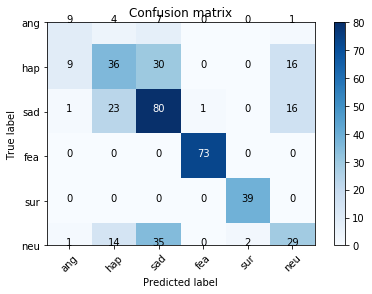

In [5]:
rf_classifier = RandomForestClassifier(n_estimators=1200, min_samples_split=25)
rf_classifier.fit(x_train, y_train)

# Predict
pred_probs = rf_classifier.predict_proba(x_test)

# Results
display_results(y_test, pred_probs)

with open('pred_probas/rf_classifier.pkl', 'wb') as f:
    pickle.dump(pred_probs, f)

Test Set Accuracy =  0.638
Test Set F-score =  0.664
Test Set Precision =  0.670
Test Set Recall =  0.667
Confusion matrix, without normalization
[[11  1  8  0  0  1]
 [ 7 36 36  1  1 10]
 [ 1 23 77  1  1 18]
 [ 0  0  0 73  0  0]
 [ 0  0  0  0 39  0]
 [ 1 10 33  0  1 36]]


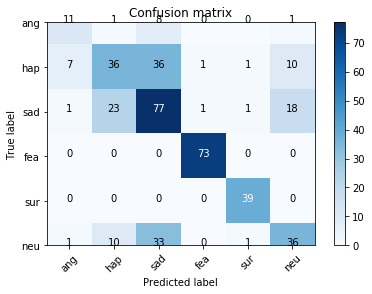

In [6]:
xgb_classifier = xgb.XGBClassifier(max_depth=7, learning_rate=0.008, objective='multi:softprob', 
                                   n_estimators=1200, sub_sample=0.8, num_class=len(emotion_dict),
                                   booster='gbtree', n_jobs=4)
xgb_classifier.fit(x_train, y_train)

# Predict
pred_probs = xgb_classifier.predict_proba(x_test)

# Results
display_results(y_test, pred_probs)

with open('pred_probas/xgb_classifier.pkl', 'wb') as f:
    pickle.dump(pred_probs, f)

Test Set Accuracy =  0.638
Test Set F-score =  0.664
Test Set Precision =  0.670
Test Set Recall =  0.667
Confusion matrix, without normalization
[[11  1  8  0  0  1]
 [ 7 36 36  1  1 10]
 [ 1 23 77  1  1 18]
 [ 0  0  0 73  0  0]
 [ 0  0  0  0 39  0]
 [ 1 10 33  0  1 36]]


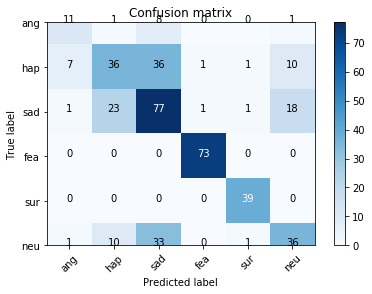

In [7]:
svc_classifier = LinearSVC()

svc_classifier.fit(x_train, y_train)

# Predict
pred = svc_classifier.predict(x_test)

# Results
display_results(y_test, pred_probs)

with open('pred_probas/svc_classifier_model.pkl', 'wb') as f:
    pickle.dump(pred, f)

Test Set Accuracy =  0.589
Test Set F-score =  0.630
Test Set Precision =  0.611
Test Set Recall =  0.655
Confusion matrix, without normalization
[[14  3  1  0  0  3]
 [ 8 31 31  0  3 18]
 [ 5 25 58  2  0 31]
 [ 0  0  0 73  0  0]
 [ 0  0  0  0 39  0]
 [ 2 18 23  0  2 36]]


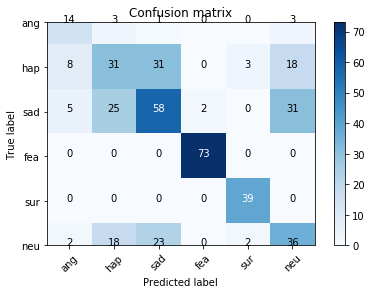

In [10]:
dt_classifier = tree.DecisionTreeClassifier()

dt_classifier.fit(x_train, y_train)

# Predict
pred_probs = dt_classifier.predict_proba(x_test)

# Results
display_results(y_test, pred_probs)

with open('pred_probas/dt_classifier.pkl', 'wb') as f:
    pickle.dump(pred_probs, f)

Test Set Accuracy =  0.577
Test Set F-score =  0.571
Test Set Precision =  0.559
Test Set Recall =  0.603
Confusion matrix, without normalization
[[ 8  4  8  1  0  0]
 [ 9 45 25  4  1  7]
 [ 7 29 63  3  3 16]
 [ 0  0  0 73  0  0]
 [ 0  0  0  0 39  0]
 [ 6 16 32  5  4 18]]


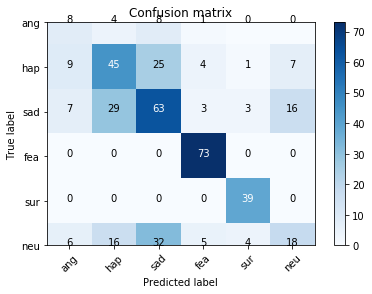

In [11]:
knn_classifier = KNeighborsClassifier(n_neighbors=4)

knn_classifier.fit(x_train, y_train)

# Predict
pred_probs = knn_classifier.predict_proba(x_test)
# Results
display_results(y_test, pred_probs)

with open('pred_probas/knn_classifier.pkl', 'wb') as f:
    pickle.dump(pred_probs, f)

Test Set Accuracy =  0.615
Test Set F-score =  0.645
Test Set Precision =  0.631
Test Set Recall =  0.664
Confusion matrix, without normalization
[[13  3  3  0  0  2]
 [ 7 31 31  0  3 19]
 [ 4 22 69  2  0 24]
 [ 0  0  0 73  0  0]
 [ 0  0  0  0 39  0]
 [ 2 15 25  0  2 37]]


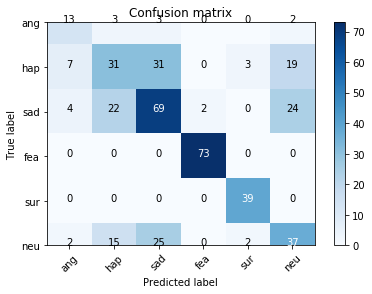

In [12]:
# Load predicted probabilities
# Load predicted probabilities
with open('pred_probas/rf_classifier.pkl', 'rb') as f:
    rf_pred_probs = pickle.load(f)

with open('pred_probas/xgb_classifier.pkl', 'rb') as f:
    xgb_pred_probs = pickle.load(f)
    
with open('pred_probas/svc_classifier_model.pkl', 'rb') as f:
    svc_preds = pickle.load(f)
    
with open('pred_probas/dt_classifier.pkl', 'rb') as f:
    dt_pred_probs = pickle.load(f)
    
with open('pred_probas/knn_classifier.pkl', 'rb') as f:
    knn_pred_probs = pickle.load(f)
    


# Average of the predicted probabilites
ensemble_pred_probs = (xgb_pred_probs +
                       dt_pred_probs +
                       rf_pred_probs)/3.0
# Show metrics
display_results(y_test, ensemble_pred_probs)

Test Set Accuracy =  0.613
Test Set F-score =  0.652
Test Set Precision =  0.638
Test Set Recall =  0.670
Confusion matrix, without normalization
[[14  2  2  0  0  3]
 [ 6 34 31  0  2 18]
 [ 3 23 65  2  0 28]
 [ 0  0  0 73  0  0]
 [ 0  0  0  0 39  0]
 [ 2 17 23  0  3 36]]


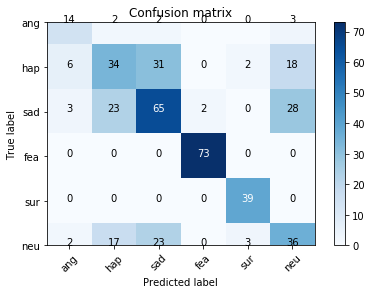

In [13]:
# Average of the predicted probabilites
ensemble_pred_probs = (knn_pred_probs +
                       dt_pred_probs +
                       rf_pred_probs)/3.0
# Show metrics
display_results(y_test, ensemble_pred_probs)

Test Set Accuracy =  0.638
Test Set F-score =  0.674
Test Set Precision =  0.663
Test Set Recall =  0.688
Confusion matrix, without normalization
[[14  2  3  0  0  2]
 [ 5 37 28  0  2 19]
 [ 3 22 71  2  0 23]
 [ 0  0  0 73  0  0]
 [ 0  0  0  0 39  0]
 [ 2 16 23  0  2 38]]


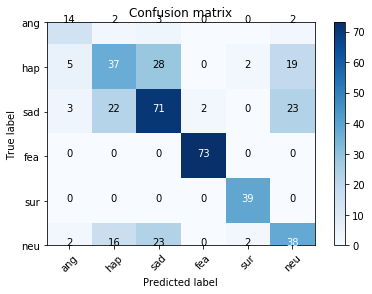

In [14]:
# Average of the predicted probabilites
ensemble_pred_probs = (knn_pred_probs +
                       dt_pred_probs +
                       xgb_pred_probs)/3.0
# Show metrics
display_results(y_test, ensemble_pred_probs)

Test Set Accuracy =  0.634
Test Set F-score =  0.652
Test Set Precision =  0.662
Test Set Recall =  0.650
Confusion matrix, without normalization
[[ 9  4  7  0  0  1]
 [ 6 39 33  1  0 12]
 [ 1 23 77  2  1 17]
 [ 0  0  0 73  0  0]
 [ 0  0  0  0 39  0]
 [ 1 14 32  0  1 33]]


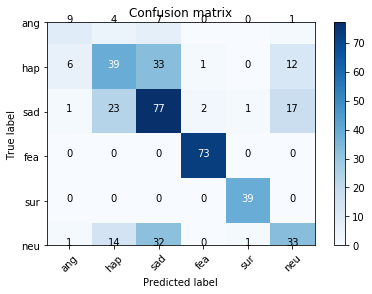

In [15]:
# Average of the predicted probabilites
ensemble_pred_probs = (knn_pred_probs +
                       xgb_pred_probs +
                       rf_pred_probs)/3.0
# Show metrics
display_results(y_test, ensemble_pred_probs)